<a href="https://colab.research.google.com/github/KD-6712/GANS/blob/main/GANS_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
#train_images = train_images[:20000]

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [ ]:
def make_generator_model():
  # Making a sequential layer of neural networks
  model = tf.keras.Sequential()
  # Creating a dense layer of fully connected neural network
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  # Applying batch normalization step to normalize the activations.
  model.add(layers.BatchNormalization())
  # Adding relu activation layer
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  # Add the convolutional 2d layer
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False))
  # Applying batch normalization step to normalize the activations
  model.add(layers.BatchNormalization())
  # Adding relu activation layer
  model.add(layers.LeakyReLU())

  # Add the convolutional 2d layer
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False))
  # Applying batch normalization step to normalize the activations
  model.add(layers.BatchNormalization())
  # Adding relu activation layer
  model.add(layers.LeakyReLU())

  # Add the final convolutional 2d transpose layer
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))

  return model

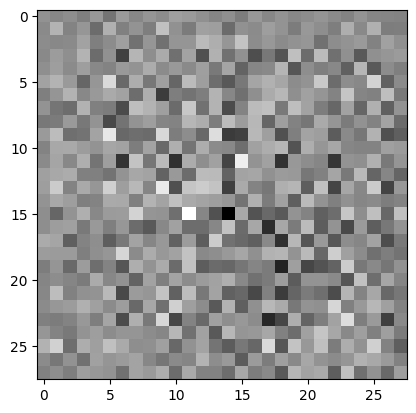

In [ ]:
# Generating an image from untrained generator
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0], cmap='gray')

In [ ]:
def make_discriminator_model():
  # Making a sequential layer of neural networks
  model = tf.keras.Sequential()
  # Adding convolutional 2d layer
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[28, 28, 1]))

  # Adding the Relu activation function
  model.add(layers.LeakyReLU())
  # Dropout randomly sets 0.3 fraction of input units to 0
  model.add(layers.Dropout(0.3))

  # Add the convolutional 2d layer
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
  # Add the relu activation function
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00120899]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  # Here compare the discriminators decisions on the generated images to an array of 1s
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 15000

# You will reuse this seed overtime
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Training starts with generator receiving a random seed as input. This seed
# is used to produce an image. The discriminator is then used to classify real
# images (drawn from the dataset) and fake images(produced by the generator)
# The loss is calculated for each of these models, and the gradients are used to update  the
# generator and the discriminator

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

   # generate_and_save_images(generator, epoch + 1, seed)

  generate_and_save_images(generator, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  print("The size of prediction is: ", predictions.shape)
  pred = predictions
  # fig = plt.figure(figsize=(4,4))
  # for i in range(predictions.shape[0]):
  #   plt.subplot(10, 10, i+1)
  #   plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  #   plt.axis('off')

  # plt.show()

In [ ]:
train(train_dataset, EPOCHS)

The size of prediction is:  (15000, 28, 28, 1)


In [ ]:
predictions = generator(seed, training=False)
disc_pred = discriminator(predictions, training=False)

In [ ]:
print(predictions.shape)

(15000, 28, 28, 1)
tf.Tensor([-0.8124418], shape=(1,), dtype=float32)


In [ ]:
predictions = tf.reshape(predictions, shape=(-1, 784))
print(predictions.shape)

(15000, 784)


In [ ]:
# 2D Visualization using PCA

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(predictions)
print(standardized_data.shape)

(15000, 784)


In [ ]:
sample_data = standardized_data

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
obj = pca.fit_transform(sample_data)
print(obj.shape)

(15000, 2)


In [ ]:
print(pca.components_)

[[ 0.02174247  0.03916603  0.05843618 ...  0.02739621  0.0199889
  -0.00462921]
 [ 0.04697871  0.01060681 -0.03085626 ... -0.01746921 -0.02246262
  -0.04230763]
 [ 0.12130568  0.10994331  0.07188555 ... -0.00554132  0.01015718
   0.02521789]]


In [ ]:
print(sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.1338711869907522
[0.05527969 0.0425274  0.03606409]


In [ ]:
var_ratio = []
nums = [10, 50, 100, 200, 300, 400, 500]
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(sample_data).transform(sample_data)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'n_components vs Explained Variance Ratio')

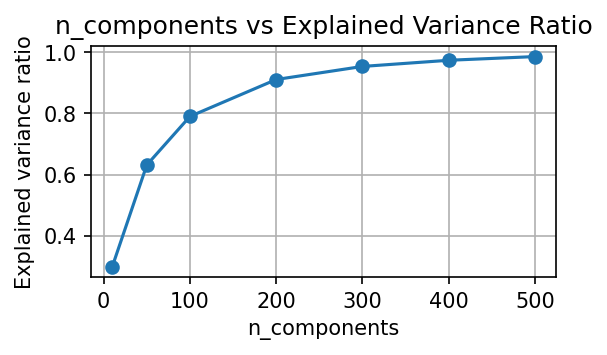

In [ ]:
plt.figure(figsize=(4,2), dpi=150)
plt.grid()
plt.plot(nums, var_ratio, marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs Explained Variance Ratio')

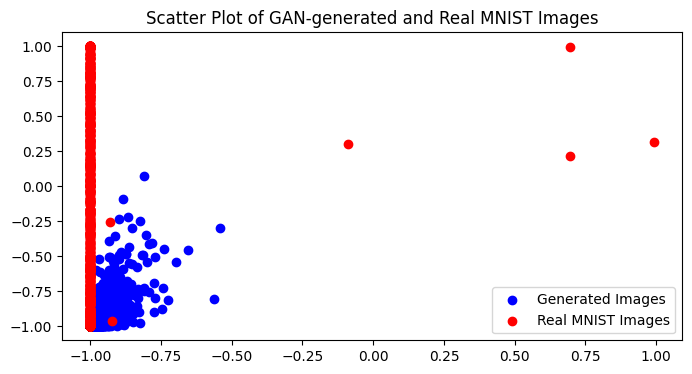

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(predictions[:, 0], predictions[:, 1], c='blue', label='Generated Images')
plt.scatter(train_images[:, 0], train_images[:, 1], c='red', label='Real MNIST Images')
plt.title('Scatter Plot of GAN-generated and Real MNIST Images')
plt.legend()
plt.show()